## Healthcare Appointment No-Show Prediction

#### Objective: Predict whether patients will miss their appointments and optimize scheduling.


In [1]:
#importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.stats.api as sms
from scipy.stats import ttest_ind
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report
import warnings
warnings.filterwarnings("ignore")

### Data Collection

In [2]:
df=pd.read_csv("healthcare_noshows.csv")

In [3]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Showed_up,Date.diff
0,2.987250e+13,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,False,True,False,False,False,False,True,0
1,5.589978e+14,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,False,False,False,False,False,False,True,0
2,4.262962e+12,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,False,False,False,False,False,False,True,0
3,8.679512e+11,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,False,False,False,False,False,False,True,0
4,8.841186e+12,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,False,True,True,False,False,False,True,0


In [4]:
df["Date.diff"].unique()

array([  0,   2,   3,   1,   4,   9,  29,  10,  23,  11,  18,  17,  14,
        28,  24,  21,  15,  16,  22,  43,  30,  31,  42,  32,  56,  45,
        46,  39,  37,  38,  44,  50,  60,  52,  53,  65,  67,  91,  66,
        84,  78,  87, 115, 109,  63,  70,  72,  57,  58,  51,  59,  41,
        73,  64,  20,  49,  33,  34,   6,  35,  36,  12,  13,  40,  47,
         8,   5,   7,  25,  26,  48,  27,  19,  61,  55,  62, 176,  77,
        69,  76,  89,  81,  79,  54,  68,  75,  85, 112,  -1,  80,  86,
        98,  94,  83, 142, 155, 162, 169, 104, 133, 125,  96,  88,  90,
       151, 126, 127, 111, 119,  74,  71,  82, 103, 108, 110, 102, 122,
       101, 105,  92,  97,  93, 107,  95,  -6, 139, 132, 179, 117, 146,
       123], dtype=int64)

In [5]:
df.shape

(106987, 15)

In [6]:
df.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship          bool
Hipertension         bool
Diabetes             bool
Alcoholism           bool
Handcap              bool
SMS_received         bool
Showed_up            bool
Date.diff           int64
dtype: object

In [7]:
df.isnull().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
Showed_up         0
Date.diff         0
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
#converting the date values into datetime
df["ScheduledDay"] = pd.to_datetime(df["ScheduledDay"])
df["AppointmentDay"] = pd.to_datetime(df["AppointmentDay"])

In [10]:
df.dtypes

PatientId                float64
AppointmentID              int64
Gender                    object
ScheduledDay      datetime64[ns]
AppointmentDay    datetime64[ns]
Age                        int64
Neighbourhood             object
Scholarship                 bool
Hipertension                bool
Diabetes                    bool
Alcoholism                  bool
Handcap                     bool
SMS_received                bool
Showed_up                   bool
Date.diff                  int64
dtype: object

In [11]:
df["SMS_received"].unique()

array([False,  True])

In [12]:
len(df[df["SMS_received"] == True])  # No. of Patients getting notified by the message when they missed the appointment

34585

### Data Preprocessing

In [13]:
df["appointment"] = df["SMS_received"].apply(lambda x:0 if x == True else 1)  #Creating target column
df.head()     # 1 for appointment and 0 for missing appointment 

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Showed_up,Date.diff,appointment
0,2.987250e+13,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,False,True,False,False,False,False,True,0,1
1,5.589978e+14,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,False,False,False,False,False,False,True,0,1
2,4.262962e+12,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,False,False,False,False,False,False,True,0,1
3,8.679512e+11,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,False,False,False,False,False,False,True,0,1
4,8.841186e+12,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,False,True,True,False,False,False,True,0,1


In [14]:
# Encode the categorical datas 
le = LabelEncoder()
cols = ["Gender","Hipertension","Diabetes","Alcoholism","SMS_received"]

for i in cols:
    df[i] = le.fit_transform(df[i])

df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Showed_up,Date.diff,appointment
0,2.987250e+13,5642903,0,2016-04-29,2016-04-29,62,JARDIM DA PENHA,False,1,0,0,False,0,True,0,1
1,5.589978e+14,5642503,1,2016-04-29,2016-04-29,56,JARDIM DA PENHA,False,0,0,0,False,0,True,0,1
2,4.262962e+12,5642549,0,2016-04-29,2016-04-29,62,MATA DA PRAIA,False,0,0,0,False,0,True,0,1
3,8.679512e+11,5642828,0,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,False,0,0,0,False,0,True,0,1
4,8.841186e+12,5642494,0,2016-04-29,2016-04-29,56,JARDIM DA PENHA,False,1,1,0,False,0,True,0,1


In [15]:
#creating new dataset with  useful columns 
new_df = df[["Gender","ScheduledDay","AppointmentDay","Age","Hipertension","Diabetes","Alcoholism","SMS_received","appointment","Date.diff"]]
new_df["Day"] = new_df["AppointmentDay"].dt.day
new_df["Month"] = new_df["AppointmentDay"].dt.month
new_df["Year"] = new_df["AppointmentDay"].dt.year
new_df["scheduled_hour"] = new_df["ScheduledDay"].dt.hour
new_df["appointment_hour"] = new_df["AppointmentDay"].dt.hour

new_df.head()

,Gender,ScheduledDay,AppointmentDay,Age,Hipertension,Diabetes,Alcoholism,SMS_received,appointment,Date.diff,Day,Month,Year,scheduled_hour,appointment_hour
0,0,2016-04-29,2016-04-29,62,1,0,0,0,1,0,29,4,2016,0,0
1,1,2016-04-29,2016-04-29,56,0,0,0,0,1,0,29,4,2016,0,0
2,0,2016-04-29,2016-04-29,62,0,0,0,0,1,0,29,4,2016,0,0
3,0,2016-04-29,2016-04-29,8,0,0,0,0,1,0,29,4,2016,0,0
4,0,2016-04-29,2016-04-29,56,1,1,0,0,1,0,29,4,2016,0,0


In [16]:
new_df["Day"].unique()

array([29,  3, 10, 17, 24, 31,  2, 30, 16,  4, 19, 12,  6, 20,  5, 13,  9,
       25, 11, 18, 14,  7,  1,  8])

In [17]:
new_df.dtypes

Gender                       int32
ScheduledDay        datetime64[ns]
AppointmentDay      datetime64[ns]
Age                          int64
Hipertension                 int64
Diabetes                     int64
Alcoholism                   int64
SMS_received                 int64
appointment                  int64
Date.diff                    int64
Day                          int32
Month                        int32
Year                         int32
scheduled_hour               int32
appointment_hour             int32
dtype: object

### Exploratory Data Analysis
#### Statistical Analysis

#### 1) Descriptive Statistics

In [18]:
#calculating 5 point summary of the dataset (min,25%,median,75%,max)

new_df.describe()

,Gender,ScheduledDay,AppointmentDay,Age,Hipertension,Diabetes,Alcoholism,SMS_received,appointment,Date.diff,Day,Month,Year,scheduled_hour,appointment_hour
count,106987.000000,106987,106987,106987.000000,106987.000000,106987.000000,106987.000000,106987.000000,106987.000000,106987.000000,106987.000000,106987.000000,106987.0,106987.0,106987.0
mean,0.344612,2016-05-08 21:18:53.330217728,2016-05-19 01:18:58.041070336,38.316085,0.203772,0.074243,0.031406,0.323264,0.676736,10.166721,12.484031,5.211026,2016.0,0.0,0.0
min,0.000000,2015-11-10 00:00:00,2016-04-29 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000,1.000000,4.000000,2016.0,0.0,0.0
25%,0.000000,2016-04-29 00:00:00,2016-05-09 00:00:00,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,5.000000,2016.0,0.0,0.0
50%,0.000000,2016-05-10 00:00:00,2016-05-18 00:00:00,38.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,10.000000,5.000000,2016.0,0.0,0.0
75%,1.000000,2016-05-20 00:00:00,2016-05-31 00:00:00,56.000000,0.000000,0.000000,0.000000,1.000000,1.000000,14.000000,19.000000,5.000000,2016.0,0.0,0.0
max,1.000000,2016-06-08 00:00:00,2016-06-08 00:00:00,115.000000,1.000000,1.000000,1.000000,1.000000,1.000000,179.000000,31.000000,6.000000,2016.0,0.0,0.0
std,0.475244,NaN,NaN,22.466214,0.402804,0.262167,0.174412,0.467725,0.467725,15.263508,9.055752,0.473837,0.0,0.0,0.0


In [19]:
new_df["Age"].mode()   # most occured age is 1

0    1
Name: Age, dtype: int64

In [20]:
new_df.skew(numeric_only = True)

Gender              0.653942
Age                 0.121644
Hipertension        1.470856
Diabetes            3.248051
Alcoholism          5.373509
SMS_received        0.755743
appointment        -0.755743
Date.diff           2.690161
Day                 0.630471
Month               0.559203
Year                0.000000
scheduled_hour      0.000000
appointment_hour    0.000000
dtype: float64

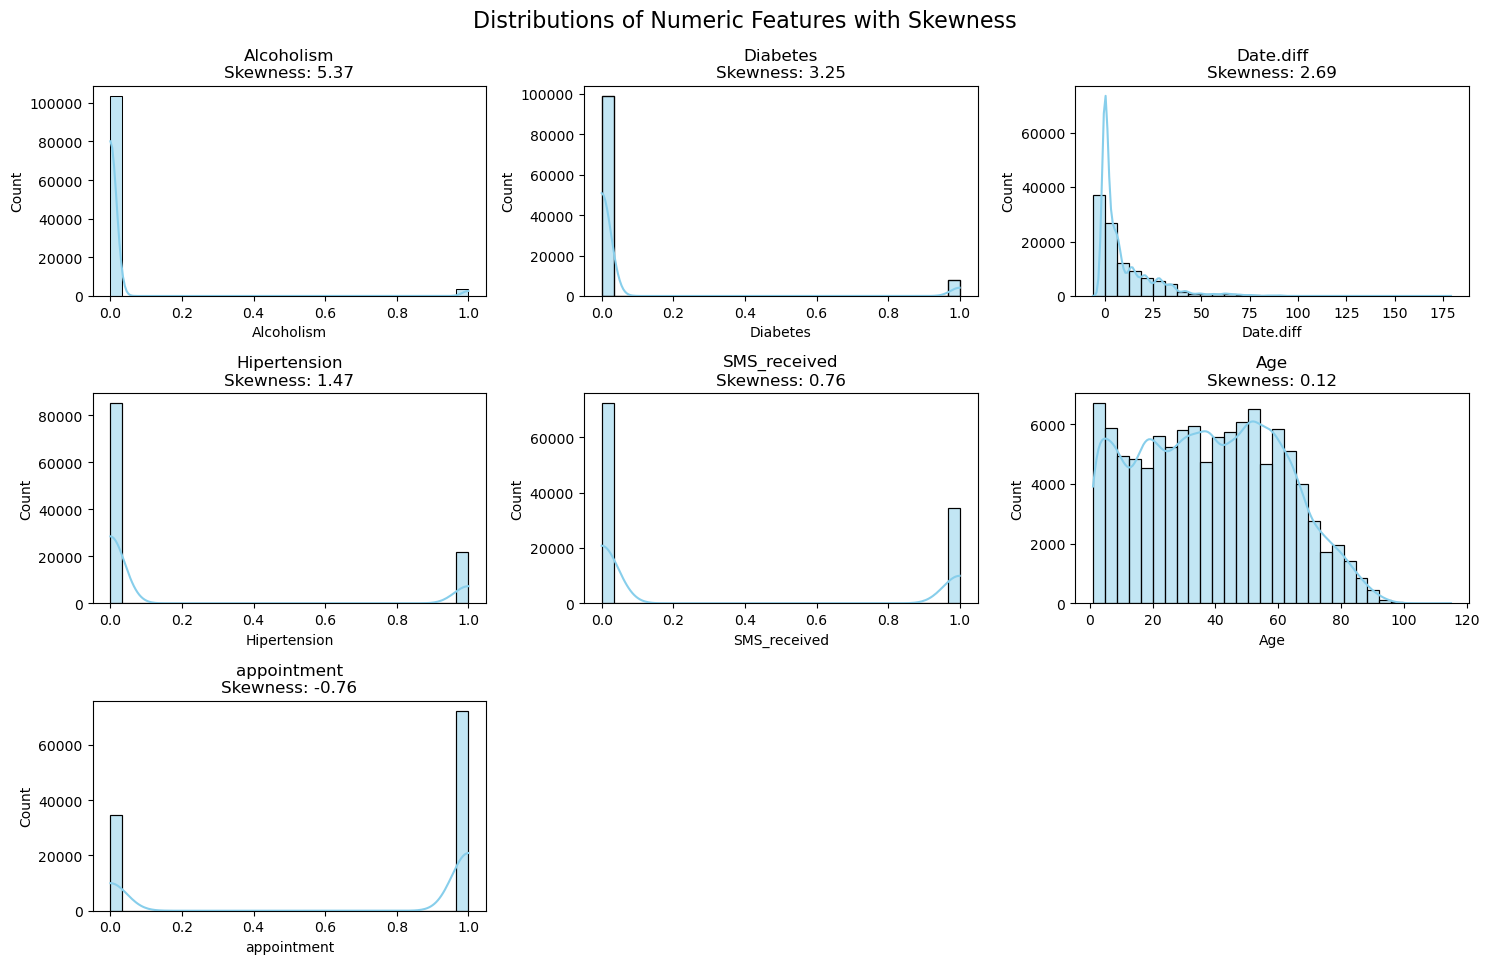

In [21]:
skewed_cols = new_df.select_dtypes(include=['float64', 'int64']).skew().sort_values(ascending=False)

# Plot
plt.figure(figsize=(15, 12))
for i, col in enumerate(skewed_cols.index):
    plt.subplot(4, 3, i + 1)
    sns.histplot(new_df[col], kde=True, bins=30, color='skyblue')
    skew_val = skewed_cols[col]
    plt.title(f'{col}\nSkewness: {skew_val:.2f}')
    plt.tight_layout()

plt.suptitle("Distributions of Numeric Features with Skewness", fontsize=16, y=1.02)
plt.show()

In [22]:
new_df.kurt(numeric_only=True)

Gender              -1.572389
Age                 -0.921592
Hipertension         0.163421
Diabetes             8.549996
Alcoholism          26.875105
SMS_received        -1.428880
appointment         -1.428880
Date.diff           12.022504
Day                 -0.756277
Month                0.111863
Year                 0.000000
scheduled_hour       0.000000
appointment_hour     0.000000
dtype: float64

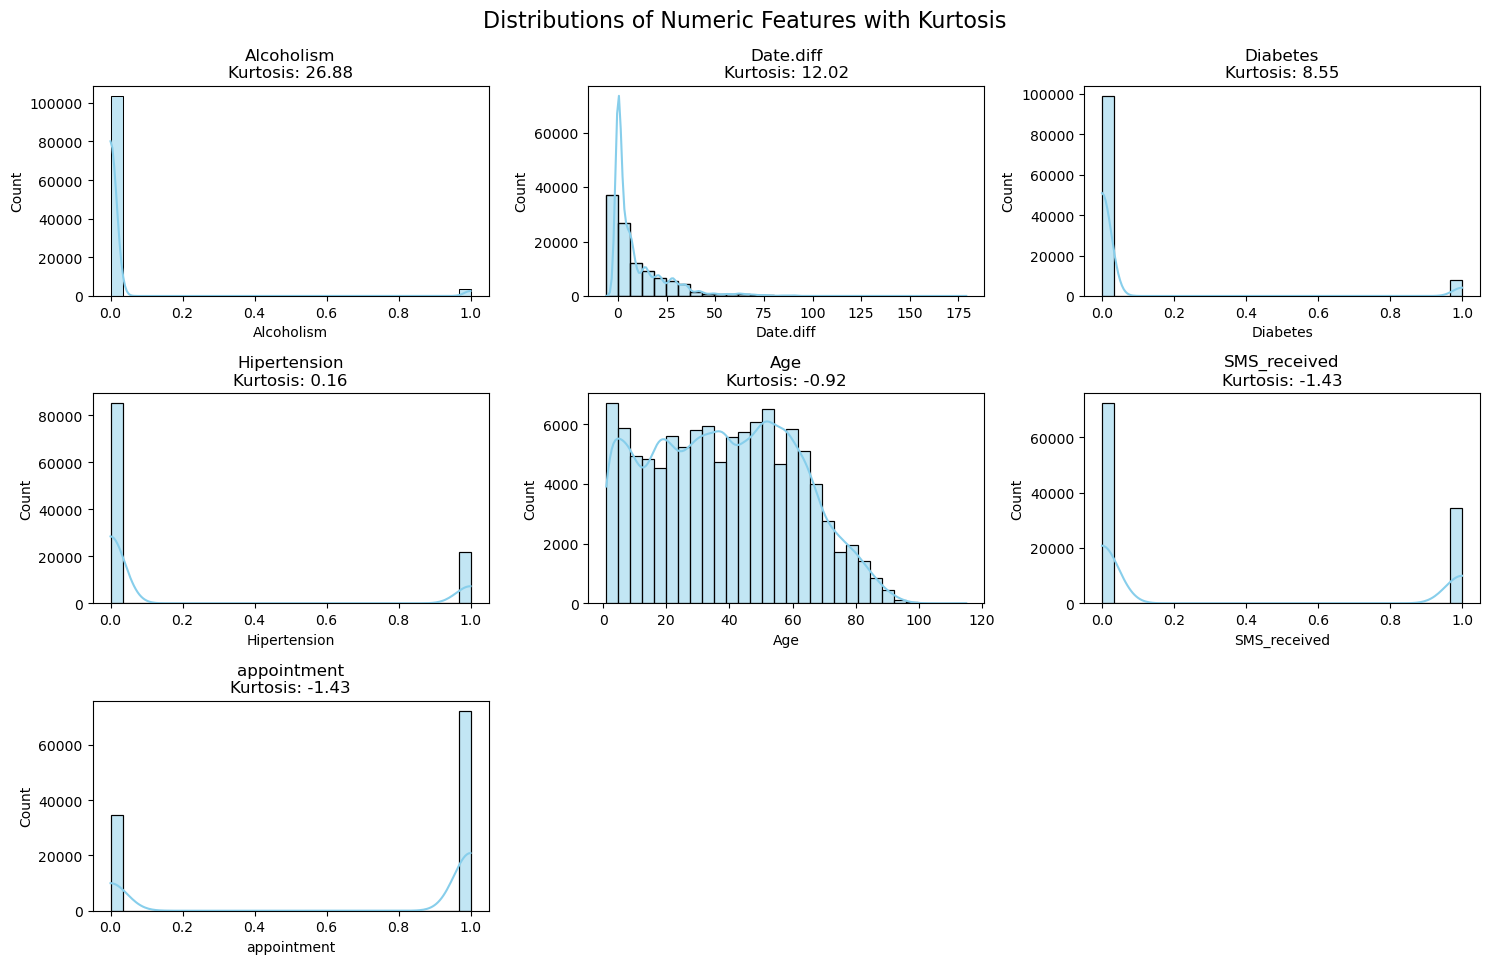

In [23]:
kurt_cols = new_df.select_dtypes(include=['float64', 'int64']).kurt().sort_values(ascending=False)

# Plot
plt.figure(figsize=(15, 12))
for i, col in enumerate(kurt_cols.index):
    plt.subplot(4, 3, i + 1)
    sns.histplot(new_df[col], kde=True, bins=30, color='skyblue')
    kurt_val = kurt_cols[col]
    plt.title(f'{col}\nKurtosis: {kurt_val:.2f}')
    plt.tight_layout()

plt.suptitle("Distributions of Numeric Features with Kurtosis", fontsize=16, y=1.02)
plt.show()

In [24]:
skewed_cols

Alcoholism      5.373509
Diabetes        3.248051
Date.diff       2.690161
Hipertension    1.470856
SMS_received    0.755743
Age             0.121644
appointment    -0.755743
dtype: float64

### 2) Inferential Statistics

In [25]:
group_show = new_df[new_df["appointment"] == 1]['Age']
No_group_show = new_df[new_df["appointment"] == 0]['Age']

In [26]:
chi2,p_value,_,_ = stats.chi2_contingency(group_show,No_group_show)
print(f"chi2 value:{chi2}\n p_value:{p_value}")

chi2 value:0.0
 p_value:1.0


In [27]:
ttest,p_value = ttest_ind(group_show,No_group_show,equal_var = False)
print(f"ttest value:{ttest}\n p_value:{p_value}")

ttest value:-1.7453934405255225
 p_value:0.0809207347877252


### Data Visualisation

In [28]:
# Age wise diabetes count
data = new_df.groupby("Diabetes")["Age"].count()

data_df = pd.DataFrame({'Diabetes':data.index,'Count':data.values})
data_df.head()
# sns.barplot(data = data_df,x = data_df["Diabetes"],y = data_df["Count"])
# plt.show()

,Diabetes,Count
0,0,99044
1,1,7943


In [29]:
#Top 10 Age wise messages received count

data1 = (new_df.groupby("Age")["SMS_received"]).value_counts().unstack()
data1.iloc[:10]

data1_df = pd.DataFrame({"Age":data1.iloc[:10].index,"SMS_received(count)":data1.iloc[:10][0].values,"SMS_not_received(count)":data1.iloc[:10][1].values})
data1_df

,Age,SMS_received(count),SMS_not_received(count)
0,1,1707.0,566.0
1,2,1225.0,393.0
2,3,1109.0,404.0
3,4,918.0,381.0
4,5,995.0,494.0
5,6,1010.0,511.0
6,7,986.0,441.0
7,8,955.0,469.0
8,9,924.0,448.0
9,10,851.0,423.0


<Figure size 1000x1000 with 0 Axes>

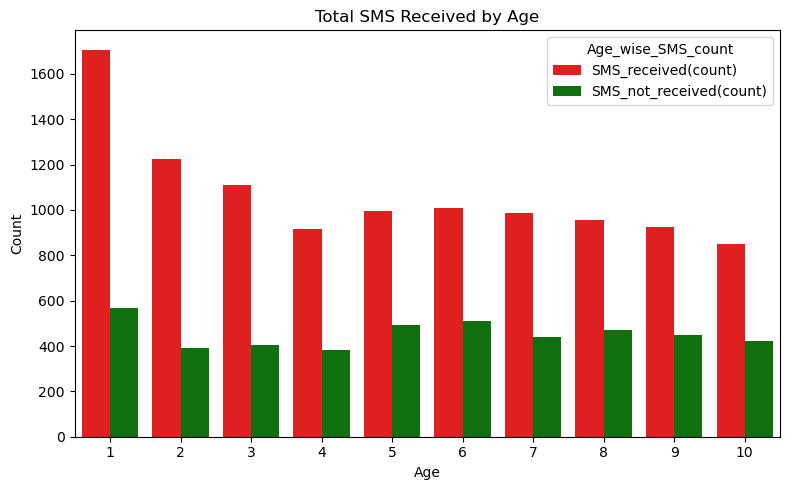

In [30]:
plt.figure(figsize = (10,10))
df_melted = data1_df.melt(id_vars = 'Age',value_vars = ["SMS_received(count)","SMS_not_received(count)"],var_name = "Age_wise_SMS_count",value_name = "Count")
df_melted
plt.figure(figsize=(8, 5))
sns.barplot(data=df_melted, x='Age', y='Count', hue='Age_wise_SMS_count',palette=["red","Green"])
plt.title('Total SMS Received by Age')
plt.tight_layout()
plt.show()

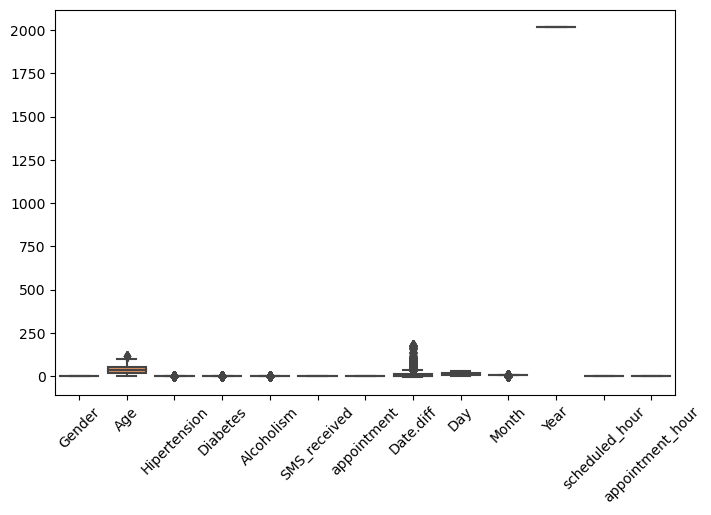

In [31]:
plt.figure(figsize=(8,5))  # Not containing high amount of outliers
sns.boxplot(new_df)
plt.xticks(rotation = 45)
plt.show()

In [32]:
#Gender wise SMS_received which means they missed the appointment 
# We can say that if SMS_received >>(high) then Appointment_miss >>>(high)
data2 = (new_df.groupby("Gender")["SMS_received"]).value_counts().unstack()
data2

SMS_received,0,1
Gender,,
0,46361,23757
1,26041,10828


In [33]:
data2_df = pd.DataFrame({"Gender":data2.index,"SMS_received(count)":data2[0].values,"SMS_not_received(count)":data2[1].values})
data2_df

,Gender,SMS_received(count),SMS_not_received(count)
0,0,46361,23757
1,1,26041,10828


<Figure size 1000x1000 with 0 Axes>

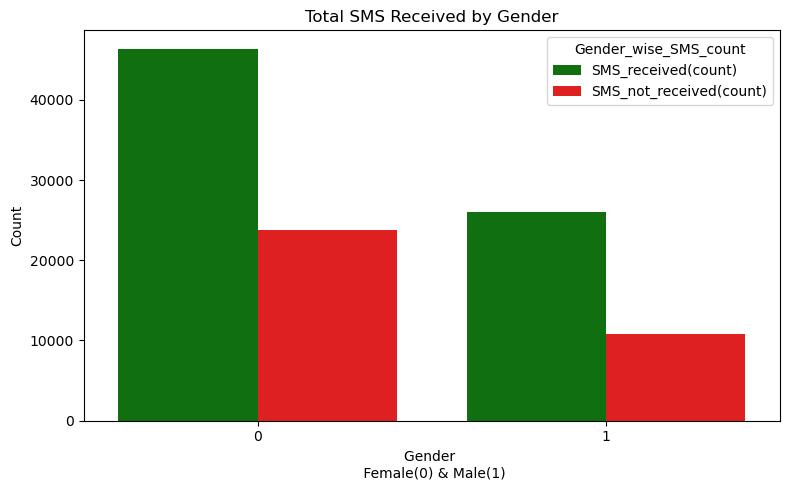

In [34]:
plt.figure(figsize = (10,10))
df_melted1 = data2_df.melt(id_vars = 'Gender',value_vars = ["SMS_received(count)","SMS_not_received(count)"],var_name = "Gender_wise_SMS_count",value_name = "Count")
df_melted1
plt.figure(figsize=(8, 5))
sns.barplot(data=df_melted1, x='Gender', y='Count', hue='Gender_wise_SMS_count',palette=["green","red"])
plt.title('Total SMS Received by Gender')
plt.xlabel("Gender \n Female(0) & Male(1)")
plt.tight_layout()
plt.show()

In [35]:
data3 = (new_df.groupby("Gender")["Hipertension"]).value_counts().unstack()
data3_df = pd.DataFrame({"Gender":data3.index,"No_Hipertension(count)":data3[0].values,"Hipertension(count)":data3[1].values})
data3_df

,Gender,No_Hipertension(count),Hipertension(count)
0,0,54779,15339
1,1,30407,6462


<Figure size 1000x1000 with 0 Axes>

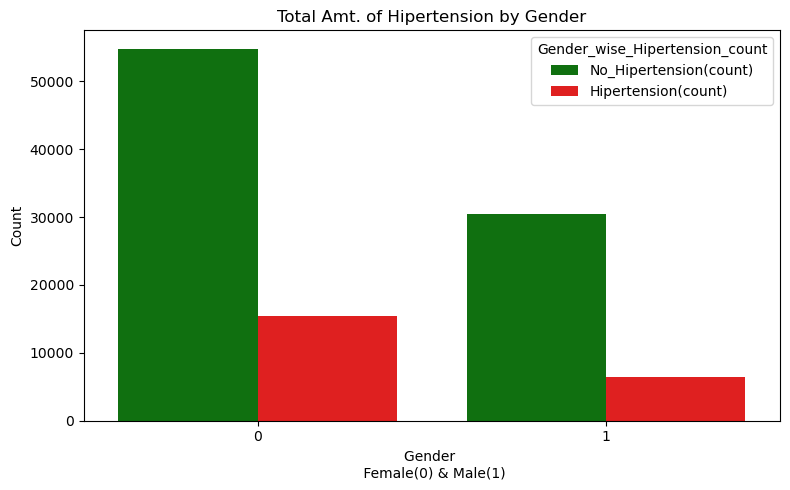

In [36]:
plt.figure(figsize = (10,10))
df_melted2 = data3_df.melt(id_vars = 'Gender',value_vars = ["No_Hipertension(count)","Hipertension(count)"],var_name = "Gender_wise_Hipertension_count",value_name = "Count")
df_melted2
plt.figure(figsize=(8, 5))
sns.barplot(data=df_melted2, x='Gender', y='Count', hue='Gender_wise_Hipertension_count',palette=["green","red"])
plt.title('Total Amt. of Hipertension by Gender')
plt.xlabel("Gender \n Female(0) & Male(1)")
plt.tight_layout()
plt.show()

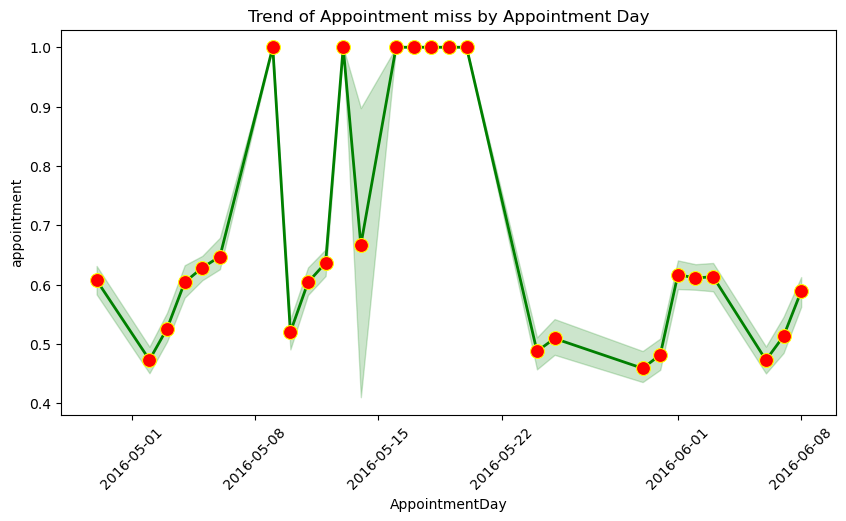

In [37]:
plt.figure(figsize = (10,5))
sns.lineplot(data = new_df,x = new_df["AppointmentDay"],y = new_df["appointment"],errorbar=('ci', 100),marker = "o",markersize = 10,linewidth = 2,color = "green")
plt.title("Trend of Appointment miss by Appointment Day")
line = plt.gca().lines[0]
line.set_markerfacecolor('red')   
line.set_markeredgecolor('yellow')
plt.xticks(rotation = 45)
plt.show()

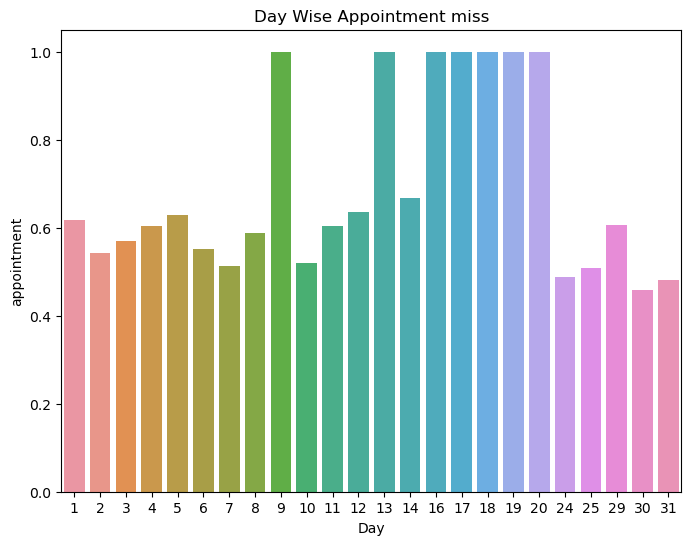

In [38]:
plt.figure(figsize = (8,6))
sns.barplot(data = new_df,x = new_df["Day"],y = new_df["appointment"],errorbar =None )
plt.title("Day Wise Appointment miss")
plt.show()

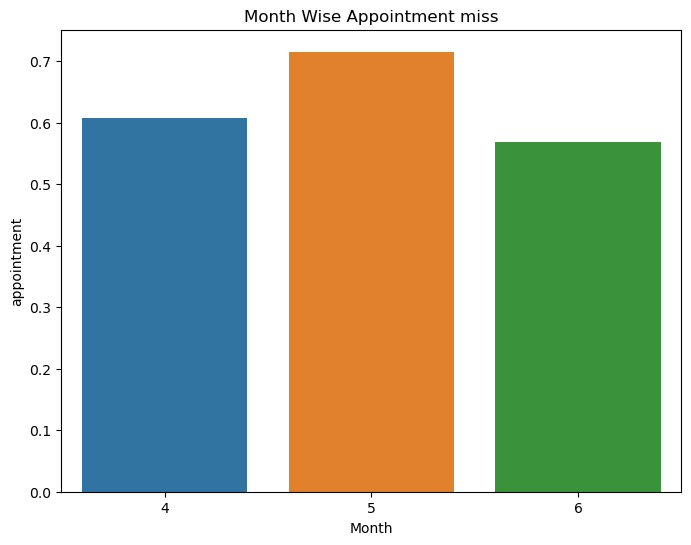

In [39]:
plt.figure(figsize = (8,6))
sns.barplot(data = new_df,x = new_df["Month"],y = new_df["appointment"],errorbar =None )
plt.title("Month Wise Appointment miss")
plt.show()

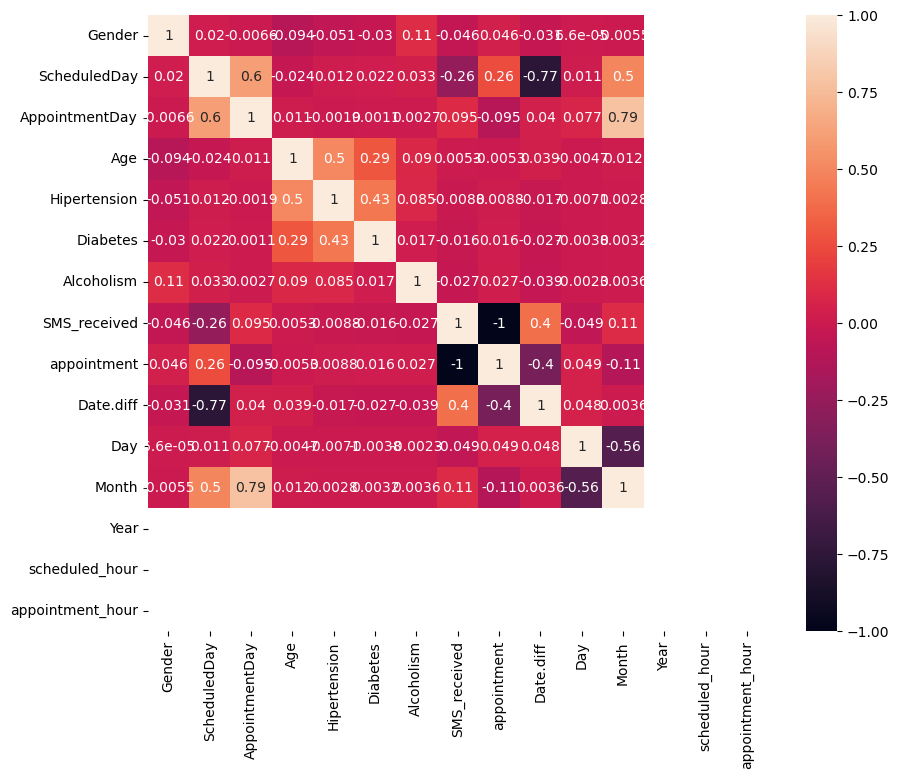

In [40]:
plt.figure(figsize = (10,8))
sns.heatmap(new_df.corr(),annot = True)
plt.show()

### Modelling

In [41]:
X = new_df.drop(["appointment","AppointmentDay","ScheduledDay"],axis = 1)
y = new_df["appointment"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state = 42)

In [42]:
X

,Gender,Age,Hipertension,Diabetes,Alcoholism,SMS_received,Date.diff,Day,Month,Year,scheduled_hour,appointment_hour
0,0,62,1,0,0,0,0,29,4,2016,0,0
1,1,56,0,0,0,0,0,29,4,2016,0,0
2,0,62,0,0,0,0,0,29,4,2016,0,0
3,0,8,0,0,0,0,0,29,4,2016,0,0
4,0,56,1,1,0,0,0,29,4,2016,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
106982,0,56,0,0,0,1,35,7,6,2016,0,0
106983,0,51,0,0,0,1,35,7,6,2016,0,0
106984,0,21,0,0,0,1,41,7,6,2016,0,0
106985,0,38,0,0,0,1,41,7,6,2016,0,0


In [43]:
dt_clf = DecisionTreeClassifier(criterion = 'gini', max_depth = 5, splitter = 'best')
dt_clf

DecisionTreeClassifier(max_depth=5)

In [44]:
dt_clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5)

In [45]:
y_pred_train = dt_clf.predict(X_train)
y_pred_train

array([0, 1, 1, ..., 1, 0, 1], dtype=int64)

In [46]:
y_pred_test = dt_clf.predict(X_test)
y_pred_test

array([0, 1, 0, ..., 1, 1, 0], dtype=int64)

### Evaluation metrics

In [47]:
print("\t\t\033[1mEvaluation metrics of DecisionTree Classifier\033[0m\n")
print(f"Accuracy score:\n \033[1m{accuracy_score(y_test,y_pred_test)}\033[0m")
print(f"Classification_report:\033[1m{classification_report(y_test,y_pred_test)}\033[0m")

		Evaluation metrics of DecisionTree Classifier

Accuracy score:
 1.0
Classification_report:              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8542
           1       1.00      1.00      1.00     18205

    accuracy                           1.00     26747
   macro avg       1.00      1.00      1.00     26747
weighted avg       1.00      1.00      1.00     26747



In [48]:
rf_clf = RandomForestClassifier()
rf_clf

RandomForestClassifier()

In [49]:
rf_clf.fit(X_train,y_train)

RandomForestClassifier()

In [50]:
y_pred_train = rf_clf.predict(X_train)
y_pred_train

array([0, 1, 1, ..., 1, 0, 1], dtype=int64)

In [51]:
y_pred_test = rf_clf.predict(X_test)
y_pred_test

array([0, 1, 0, ..., 1, 1, 0], dtype=int64)

In [52]:
print("\t\t\033[1mEvaluation metrics of RandomForest Classifier\033[0m\n")
print(f"Accuracy score:\n \033[1m{accuracy_score(y_test,y_pred_test)}\033[0m")
print(f"Classification_report:\033[1m{classification_report(y_test,y_pred_test)}\033[0m")

		Evaluation metrics of RandomForest Classifier

Accuracy score:
 1.0
Classification_report:              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8542
           1       1.00      1.00      1.00     18205

    accuracy                           1.00     26747
   macro avg       1.00      1.00      1.00     26747
weighted avg       1.00      1.00      1.00     26747



### HyperParameter Tuning

In [53]:
params = {
     "criterion":['gini', 'entropy', 'log_loss'],
    "splitter":['best', 'random'],
    "max_depth":[5,7,10]    
 }

In [54]:
grid_cv = GridSearchCV(estimator = dt_clf ,param_grid = params,cv = 5,verbose = 1)
grid_cv

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(max_depth=5),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [5, 7, 10],
                         'splitter': ['best', 'random']},
             verbose=1)

In [55]:
grid_cv.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(max_depth=5),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [5, 7, 10],
                         'splitter': ['best', 'random']},
             verbose=1)

In [56]:
grid_cv.best_params_

{'criterion': 'gini', 'max_depth': 5, 'splitter': 'best'}

In [57]:
grid_cv.best_score_

1.0

In [58]:
grid_cv.best_estimator_

DecisionTreeClassifier(max_depth=5)

In [59]:
new_df.head()

,Gender,ScheduledDay,AppointmentDay,Age,Hipertension,Diabetes,Alcoholism,SMS_received,appointment,Date.diff,Day,Month,Year,scheduled_hour,appointment_hour
0,0,2016-04-29,2016-04-29,62,1,0,0,0,1,0,29,4,2016,0,0
1,1,2016-04-29,2016-04-29,56,0,0,0,0,1,0,29,4,2016,0,0
2,0,2016-04-29,2016-04-29,62,0,0,0,0,1,0,29,4,2016,0,0
3,0,2016-04-29,2016-04-29,8,0,0,0,0,1,0,29,4,2016,0,0
4,0,2016-04-29,2016-04-29,56,1,1,0,0,1,0,29,4,2016,0,0


### Actual Predictor

In [61]:
Gender = input("Enter the Gender:").capitalize()
if Gender == "Male":
    Gender = 1
elif Gender == "Female":
    Gender = 0
else:
    print("Incorrect Gender!!")

Age = int(input("Enter the Age:"))

Hipertension = input("Do you have Hipertension? :").capitalize()
if Hipertension == "Yes":
    Hipertension = 1
elif Hipertension == "No":
    Hipertension = 0
else:
    print("Incorrect Hipertension value!!")

    
Diabetes = input("Do you have Diabetes? :").capitalize()   
if Diabetes == "Yes":
    Diabetes = 1
elif Diabetes == "No":
    Diabetes = 0
else:
    print("Incorrect Diabetes value!!")
    

Alcoholism = input("Do you Drink Alcohol? :").capitalize()
if Alcoholism == "Yes":
    Alcoholism = 1
elif Alcoholism == "No":
    Alcoholism = 0
else:
    print("Incorrect value!!")


SMS_received = input("Have You received reminder related to Appointment? :").capitalize() 
if SMS_received == "Yes":
    SMS_received = 1
elif SMS_received == "No":
    SMS_received = 0
else:
    print("Incorrect value!!")
    
date_diff = int(input("Enter if any date difference is there?"))
Day = input("Enter the Date:")
Month = input("Enter the Month:")
Year = input("Enter the Year:")
scheduled_hr = input("Enter the Hour of Scheduling")
appointment_hr = input("Enter the Hour of Appointment")
result = rf_clf.predict([[Gender,Age,Hipertension,Diabetes,Alcoholism,SMS_received,date_diff,Day,Month,Year,scheduled_hr,appointment_hr]])
if result == 0:
    print("\n\033[1mOops!! You are Likely to miss an Appointment\033[0m")
elif result == 1:
    print("\n\033[1mCongrats!! You are Likely to attend the Appointment\033[0m")
else:
    print("\n\033[1mInvalid values entered\033[0m")

Enter the Gender:male
Enter the Age:34
Do you have Hipertension? :yes
Do you have Diabetes? :no
Do you Drink Alcohol? :no
Have You received reminder related to Appointment? :yes
Enter if any date difference is there?4
Enter the Date:5
Enter the Month:6
Enter the Year:2025
Enter the Hour of Scheduling10
Enter the Hour of Appointment5

Oops!! You are Likely to miss an Appointment


In [ ]:
def recommend_better_slot(patient_row, model):
    recommendations = []
    
    for day in range(0, 7):  # Monday to Sunday
        for hour in [8, 10, 12, 14, 16]:  # Try different times
            test_case = {
                'Gender':patient_row["Gender"],
                'Age': patient_row['Age'],
                'Hipertension': patient_row['Hipertension'],
                'Diabetes': patient_row['Diabetes'],
                'Alcoholism': patient_row['Alcoholism'],
                'SMS_received': 1,  # assume reminder is sent
                'Date.diff': 2,
                'Day': day,
                'Month':patient_row["Month"],
                'Year':patient_row["Year"],
                'scheduled_hour': 10,
                'appointment_hour': hour
            }
            prob = model.predict_proba(pd.DataFrame([test_case]))[0][1]  # probability of no-show
            recommendations.append(((day, hour), prob))
    
    # Sort by lowest no-show probability
    best_day_hour = sorted(recommendations, key=lambda x: x[1])[0]
    return best_day_hour


In [ ]:
missed_df = new_df[new_df["appointment"]==1][:100]
missed_df['Recommended_Slot'] = missed_df.apply(lambda row: recommend_better_slot(row,rf_clf ), axis=1)
missed_df.head()

### Summary

* I have Performed the ML pipeline onto the **"Healthcare_NoShows.csv file"** which includes the various steps:
* Steps of ML Pipeline:

  * **Data Collection:**
      * Here I have gathered the data by the reference of Kaggle:https://www.kaggle.com/datasets/joniarroba/noshowappointments
      
    
  * **Data Preprocessing:**
      * The datatypes of the columns are not appropriate. so I have converted that such as converting dates into Datetime    column,etc.
      
  * **Exploratory Data Analysis:**
      * I have performed the **Descriptive Statistics** and **Inferential Statistics** on the available data.
      * **Descriptive Statistics Results:**
      
          1) Avg. Age of Patients is 38yrs.
          
          2)  Performed Skewness and Kurtosis onto the data and obtained that most of the useful column follows the Normal Distribution.
          
      * **Inferential Analysis:**
      
          1) Performed the Chi2 test and ttest between patients Shows and No shows and obtained that there is no significant relationship exists between them.
          
  * **Data Visualisation:**
  
      * Created the helpful visuals which draws various insights out of the data such as:
          1) Created a Barplot for visualising the count of patients whi are diabetic or not? **99044 are non diabetic ,7943 are diabetic.**
          
          2) Created a gender wise appointment miss bar chart which shows that **female misses the most of the appointments i.e 46361 and Male:26041.** 
          
          3) Visualise the trend of the appointment miss by making the lineplot between appointment days and appointment found that between the dates of **15/05/2016 to 22/05/2016 there is very less amount of appointment miss observed.**
          
          4) Also plotted month wise Appointment miss and found that **May month observed the maximum miss in appointment.**
          
  * **Data Modelling:**
      
      * Created the model by following the train_test_split and using **DecisionTreeClassifier and RandomForestClassifer as the primary model whicb bring the max accuracy of 100% over the data.**
      
  * **Evaluation metrics:**
  
      * Used the Evaluation metrics such as **Accuracy_score() and classification_report() for determining the accuracy of model and found the 100% accuracy.**
      
  * **Hyperparameter tuning:**
      
      * This is optional in my case as it is used when the model performed not well onto the data and we want to increase the accuracy of the model. SO basically,I have used **GridSearchCV()** which takes on various parameter and determines the best parameters on which the model performs well.
      
      
  * **Actual Predictor:**
      
      * Finally I have created a User Interface which helps the user to get the prediction based on their desired inputs.